# 12 — Mini Project: Prediction Pipeline

## Project brief
Build and evaluate a model to predict house prices from synthetic features.

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

rng = np.random.default_rng(123)
n = 500

df = pd.DataFrame({
    "sqft": rng.normal(1600, 500, n).clip(400, 5000),
    "bedrooms": rng.integers(1, 6, n),
    "age": rng.integers(0, 60, n),
    "neighborhood": rng.choice(["A", "B", "C", "D"], n),
})

base = 50000 + df["sqft"] * 180 + df["bedrooms"] * 10000 - df["age"] * 800
neigh_boost = df["neighborhood"].map({"A": 90000, "B": 50000, "C": 20000, "D": 0})
noise = rng.normal(0, 25000, n)

df["price"] = base + neigh_boost + noise

df.head()

,sqft,bedrooms,age,neighborhood,price
0,1105.439325,4,35,B,352042.766765
1,1416.106674,2,20,A,442385.047490
2,2243.962631,4,42,A,597843.110004
3,1696.987210,1,29,A,442717.440423
4,2060.115450,4,43,A,537408.626974


In [14]:
X = df.drop(columns=["price"])
y = df["price"]

num_cols = ["sqft", "bedrooms", "age"]
cat_cols = ["neighborhood"]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols),
])

model = RandomForestRegressor(n_estimators=200, random_state=42)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", model),
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("MAE:", round(mean_absolute_error(y_test, pred), 2))
print("R2:", round(r2_score(y_test, pred), 3))

MAE: 28001.84
R2: 0.893


## Extension ideas
- Try GradientBoostingRegressor or XGBoost
- Add cross-validation
- Inspect feature importances

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Build GradientBoosting pipeline
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

gb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", gb_model),
])

# Cross-validation
cv_scores = cross_val_score(gb_pipe, X_train, y_train, cv=5, scoring='r2')
print("GradientBoosting CV R² scores:", cv_scores)
print("Mean CV R²:", round(cv_scores.mean(), 3), "± Std:", round(cv_scores.std(), 3))

# Train and evaluate on test set
gb_pipe.fit(X_train, y_train)
gb_pred = gb_pipe.predict(X_test)

print("\nTest Set Performance:")
print("MAE:", round(mean_absolute_error(y_test, gb_pred), 2))
print("R2:", round(r2_score(y_test, gb_pred), 3))

GradientBoosting CV R² scores: [0.90597609 0.90664953 0.89566568 0.86445653 0.85326896]
Mean CV R²: 0.885 ± Std: 0.022

Test Set Performance:
MAE: 28332.92
R2: 0.891


Feature Importances:
          feature  importance
0            sqft    0.832765
3  neighborhood_A    0.077798
2             age    0.042829
1        bedrooms    0.022333
4  neighborhood_B    0.012649
6  neighborhood_D    0.007716
5  neighborhood_C    0.003910


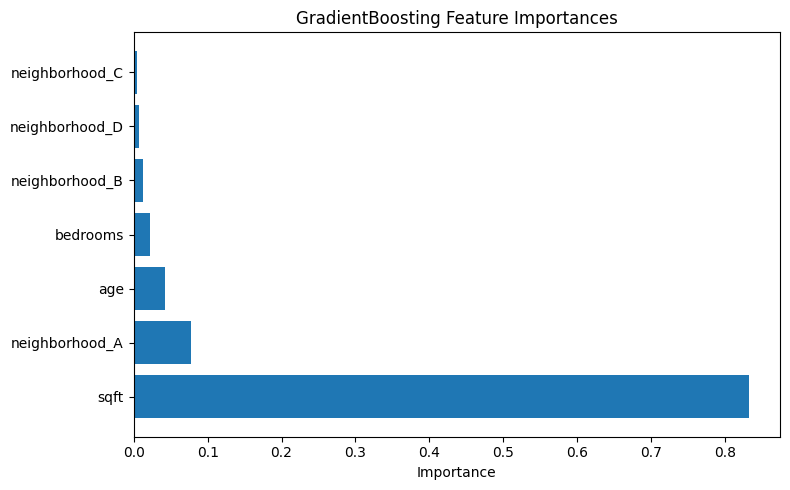

In [16]:
import matplotlib.pyplot as plt

# Extract feature importances from the trained GradientBoosting model
feature_names = (
    num_cols + 
    list(gb_pipe.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(cat_cols))
)

importances = gb_pipe.named_steps['model'].feature_importances_

# Create DataFrame and sort
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Feature Importances:")
print(importance_df)

# Visualize
plt.figure(figsize=(8, 5))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('GradientBoosting Feature Importances')
plt.tight_layout()
plt.show()